In [78]:
import dask.dataframe as dd
import pandas as pd
import os
import csv
import traceback
import logging
import numpy as np
import geopandas as gp
stationarity_map = {}
with open("/home/blakemoss/911_modeling/data_retrieval/911_data_sources.csv") as source_csv:
    dataset_path = "/home/blakemoss/911_modeling/data_retrieval/csvs/"
    reader = csv.DictReader(source_csv)
    a = 0
    for row in reader:
        try:
            if row["Saved File Name"] != "" and row["Unique ID"] != "" and "N/A" not in row['Assigned Timestamp']:
                filename = row['Saved File Name']
                if "boulder" not in filename:
                    c = row["First Entered/Call Received Timestamp"].lower()
                    d = row['Assigned Timestamp'].lower()
                else:
                    c = row["First Entered/Call Received Timestamp"]
                    d = row['Assigned Timestamp']
                path = "{}{}".format(dataset_path, filename)
                unique_id = row["Unique ID"]
                columns = [unique_id, c, d]
                if "sf" in filename:
                    df = dd.read_csv(path, usecols=columns, error_bad_lines=False, engine="python", dtype={unique_id:object})
                    df = df.drop_duplicates(subset=unique_id)
                else:
                    df = dd.read_csv(path, usecols=columns, dtype={unique_id:object})
                df[c] = dd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
                df[d] = dd.to_datetime(df[d], errors="coerce", infer_datetime_format=True)
                df = df.dropna()
                df = df.compute()
                df = df.sort_values(by=c,ascending=True)
                df['service_time'] = (df[d]-df[c]).dt.seconds.fillna(np.float64(0))
                df = df[df['service_time']!= np.float64(0)]
                df.index = df[c]
                only_hour_groups = df.groupby([df.index.hour])
                calls_time_of_day = only_hour_groups[unique_id].count()
                service_per_time_of_day = only_hour_groups['service_time'].mean()
                hour_groups = df.groupby([df.index.year, df.index.month, df.index.day, df.index.hour])
                average_service_time = hour_groups['service_time'].mean()
                total_arrival_count = hour_groups[unique_id].count()
                stationarity_map[filename] = {"service_time_of_day": service_per_time_of_day, "calls_time_of_day":calls_time_of_day, "arrivals":total_arrival_count.values, "avg service time": average_service_time.values}
                print("Loaded {}: {}".format(filename, len(df[unique_id])), flush=True)
                a += len(df[unique_id])


        except Exception as e:
            logging.error(traceback.format_exc())
    print(a) 


Loaded boulder_fire_rescue_2015_2019.csv: 68903
Loaded richmond_pd_2014_2018.csv: 25620


ERROR:root:Traceback (most recent call last):
  File "/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/pandas/io/parsers.py", line 2712, in _handle_usecols
    col_indices.append(usecols_key.index(col))
ValueError: 'received_dttm' is not in list

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-78-5b19879b7c69>", line 28, in <module>
    df = dd.read_csv(path, usecols=columns, error_bad_lines=False, engine="python", dtype={unique_id:object})
  File "/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/dask/dataframe/io/csv.py", line 578, in read
    **kwargs
  File "/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/dask/dataframe/io/csv.py", line 444, in read_pandas
    head = reader(BytesIO(b_sample), **kwargs)
  File "/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/pandas/io/parsers.py", line 

Loaded cin_pd_2019.csv: 244201
Loaded no_pd_2019.csv: 224209
Loaded nyc_ems_2019.csv: 1513331
Loaded nyc_fd_2018.csv: 616000
2692264


In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import statsmodels.tsa.stattools as tsa

In [76]:
def plot_line_graph(name, obj):
    for typ, counts in obj.items():
        fig, ax = plt.subplots()
        x = [a for a in range(len(counts))]
        ax.plot(x,counts,'k')
        ax.set_title("Line Graph through Year {}, {}".format(name, typ))
        if typ == "arrivals":
            ax.set_ylabel("# of Incidents")
            ax.set_label("Hour Timesteps Through Year")
        elif typ == "avg service time":
            ax.set_ylabel("Average Service Time")
            ax.set_label("Hour Timesteps Through Year")
        elif typ == "service_time_of_day":
            ax.set_ylabel("Average Service Time")
            ax.set_xlabel("Hour of the Day")
        else:
            ax.set_ylabel("Total # of Incidents per hour of the day")
            ax.set_xlabel("Hour of the Day")
        
        print("{}, {} ADF Tests (More negative means less likely to have unit root)".format(name, typ))
        print(tsa.adfuller(counts))
    
    
    print("{}, {} Covariance Matrix".format(name, typ))
    _,_, arr, serv = obj.values()
    print("{}: {}".format(len(arr), len(serv)))
    print(np.cov([arr, serv]))   
    print("{}, {} Correlation Matrix".format(name, typ))
    print(st.spearmanr(arr,serv))
    fig, ax = plt.subplots()
    ax.plot(arr,serv,'bo')

boulder_fire_rescue_2019.csv, service_time_of_day ADF Tests (More negative means less likely to have unit root)
(-3.500523290682266, 0.00797366501437149, 0, 23, {'1%': -3.7529275211638033, '5%': -2.998499866852963, '10%': -2.6389669754253307}, 91.84161991754388)
boulder_fire_rescue_2019.csv, calls_time_of_day ADF Tests (More negative means less likely to have unit root)
(-2.5223452106931985, 0.1101317199422, 8, 15, {'1%': -3.9644434814814815, '5%': -3.0849081481481484, '10%': -2.6818144444444445}, 151.6610722170262)
boulder_fire_rescue_2019.csv, arrivals ADF Tests (More negative means less likely to have unit root)
(-13.680208339290433, 1.4052650168020423e-25, 22, 6502, {'1%': -3.4313561340427703, '5%': -2.861984625058653, '10%': -2.5670066705661205}, 20998.23506237886)
boulder_fire_rescue_2019.csv, avg service time ADF Tests (More negative means less likely to have unit root)
(-29.745976763686013, 0.0, 5, 6519, {'1%': -3.431353509250488, '5%': -2.861983465321107, '10%': -2.56700605321

/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_l

(-11.255811768227742, 1.6682648184457822e-20, 28, 8728, {'1%': -3.4310994528274854, '5%': -2.861871208252867, '10%': -2.5669462971858117}, 57721.35355228287)
no_pd_2019.csv, avg service time ADF Tests (More negative means less likely to have unit root)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


(-11.16708119610988, 2.69754043775877e-20, 34, 8722, {'1%': -3.431099968539641, '5%': -2.86187143613454, '10%': -2.5669464184887825}, 154326.03156010777)
no_pd_2019.csv, avg service time Covariance Matrix
8757: 8757
[[1.13489449e+02 9.38924667e+03]
 [9.38924667e+03 4.80114993e+06]]
no_pd_2019.csv, avg service time Correlation Matrix
SpearmanrResult(correlation=0.4691874419823886, pvalue=0.0)
nyc_ems_2019.csv, service_time_of_day ADF Tests (More negative means less likely to have unit root)
(-1.168098133071308, 0.6871663889245385, 1, 22, {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}, 121.32311631601931)
nyc_ems_2019.csv, calls_time_of_day ADF Tests (More negative means less likely to have unit root)
(-3.4541194431044273, 0.009246614606841397, 1, 22, {'1%': -3.769732625845229, '5%': -3.005425537190083, '10%': -2.6425009917355373}, 234.59465140646302)
nyc_ems_2019.csv, arrivals ADF Tests (More negative means less likely to have unit root)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures crea

(-10.86328691526041, 1.4283100640269652e-19, 37, 8721, {'1%': -3.4311000545606776, '5%': -2.861871474145309, '10%': -2.566946438722175}, 74966.54380079651)
nyc_ems_2019.csv, avg service time ADF Tests (More negative means less likely to have unit root)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


(-14.01992929626328, 3.5865418813050674e-26, 27, 8731, {'1%': -3.431099195237286, '5%': -2.8618710944295014, '10%': -2.566946236596859}, 110023.76773118522)
nyc_ems_2019.csv, avg service time Covariance Matrix
8759: 8759
[[ 2891.03884691  1672.10193172]
 [ 1672.10193172 26868.41336071]]
nyc_ems_2019.csv, avg service time Correlation Matrix
SpearmanrResult(correlation=0.6051143073048679, pvalue=0.0)
nyc_fd_2018.csv, service_time_of_day ADF Tests (More negative means less likely to have unit root)
(-1.8679378105537527, 0.34729118269846515, 9, 14, {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}, 87.08310806421593)
nyc_fd_2018.csv, calls_time_of_day ADF Tests (More negative means less likely to have unit root)
(-1.507384517159007, 0.5298552123159184, 9, 14, {'1%': -4.01203360058309, '5%': -3.1041838775510207, '10%': -2.6909873469387753}, 233.4147961604965)
nyc_fd_2018.csv, arrivals ADF Tests (More negative means less likely to have unit root)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures crea

(-11.124476884613982, 3.401167634787985e-20, 36, 8722, {'1%': -3.431099968539641, '5%': -2.86187143613454, '10%': -2.5669464184887825}, 68008.77456072677)
nyc_fd_2018.csv, avg service time ADF Tests (More negative means less likely to have unit root)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


(-26.02992847696391, 0.0, 10, 8748, {'1%': -3.4310977388976402, '5%': -2.861870450905299, '10%': -2.566945894044578}, 87200.48982049762)
nyc_fd_2018.csv, avg service time Covariance Matrix
8759: 8759
[[ 756.96341713  305.49728378]
 [ 305.49728378 1927.10254096]]
nyc_fd_2018.csv, avg service time Correlation Matrix
SpearmanrResult(correlation=0.4705783229475224, pvalue=0.0)


/home/blakemoss/.virtualenvs/911_modeling-CJoBgkS_/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


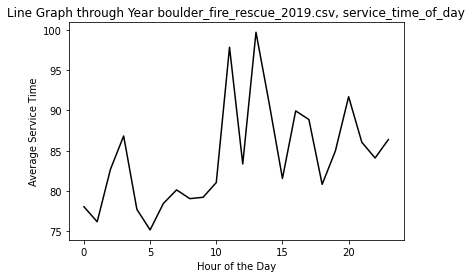

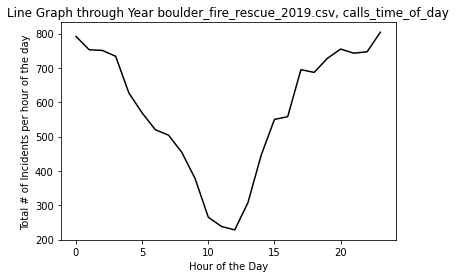

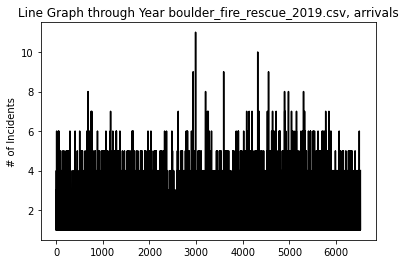

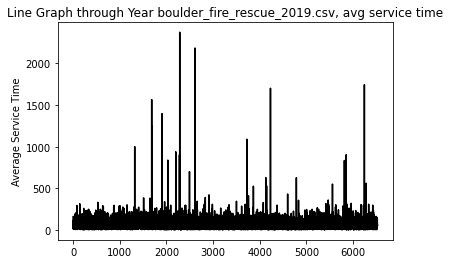

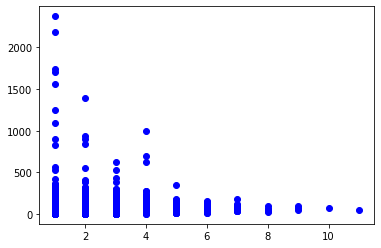

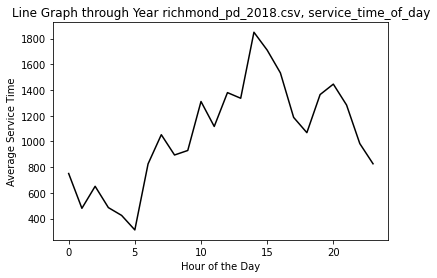

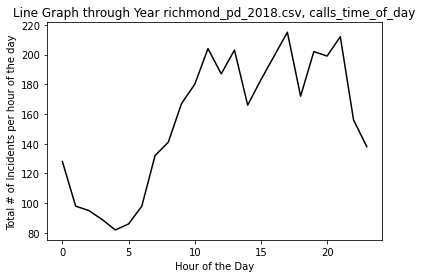

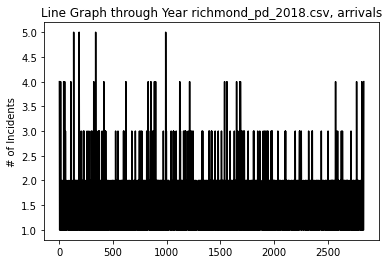

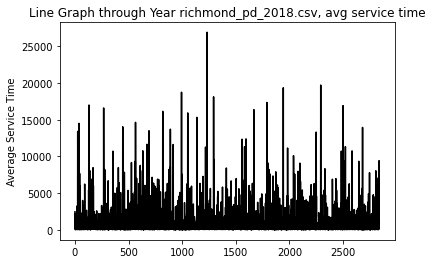

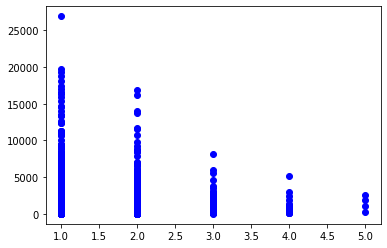

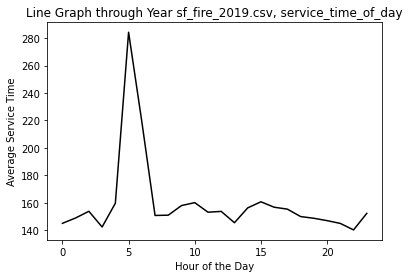

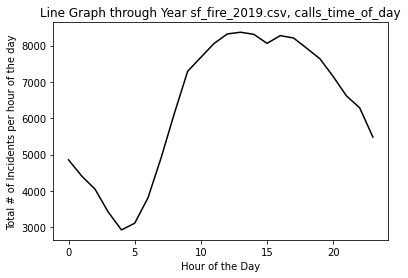

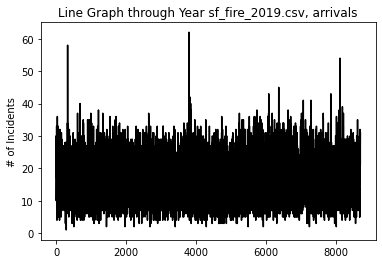

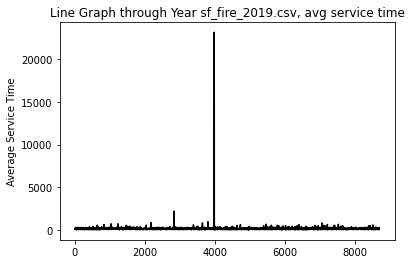

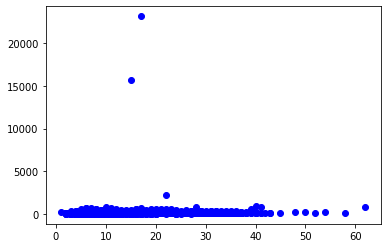

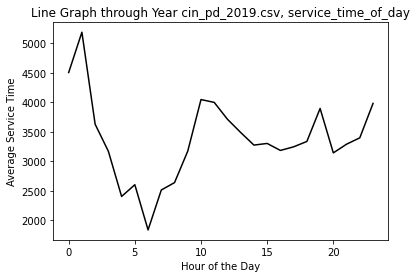

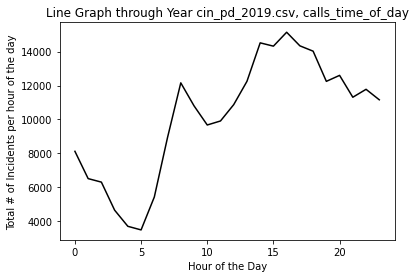

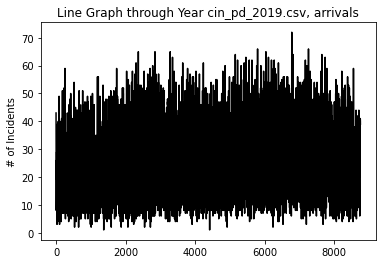

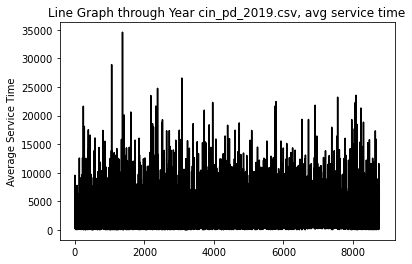

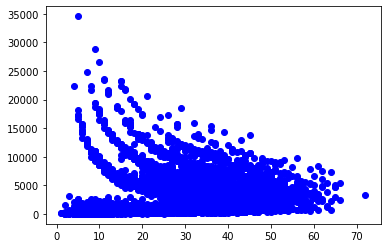

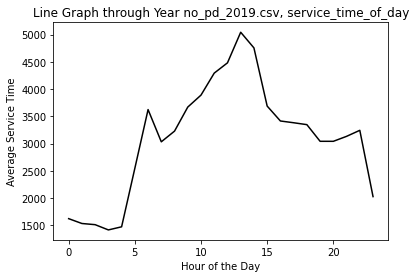

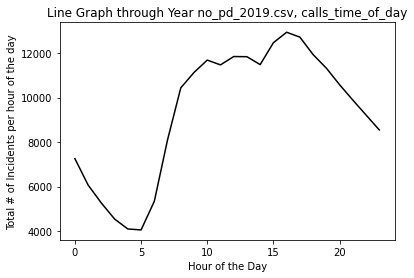

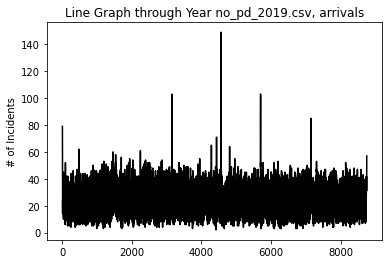

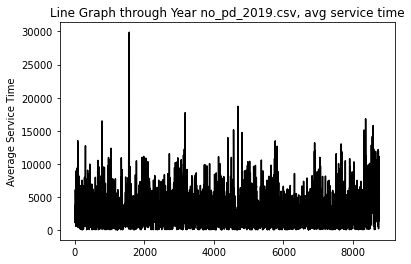

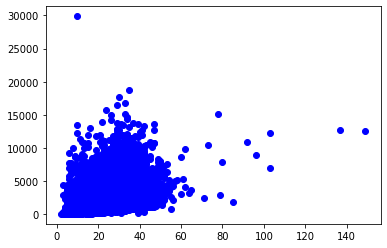

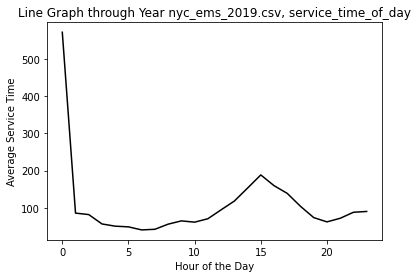

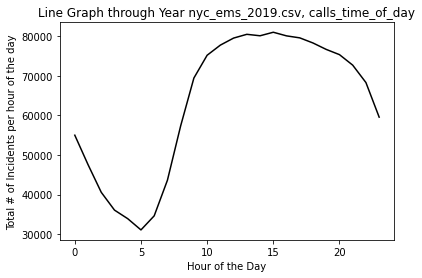

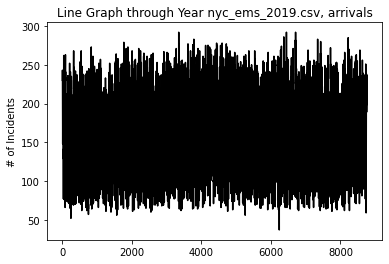

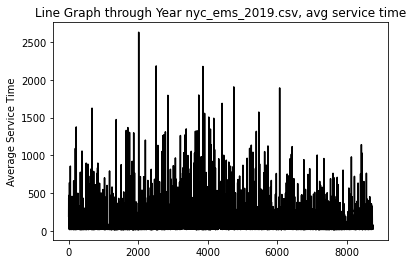

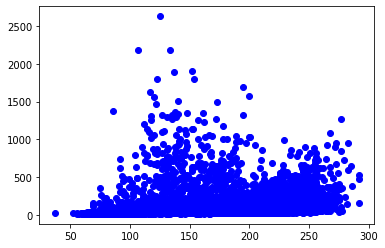

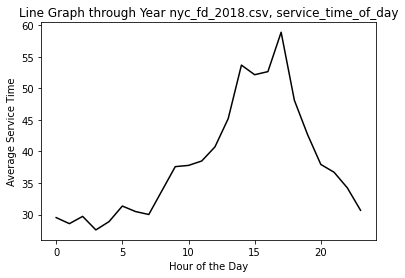

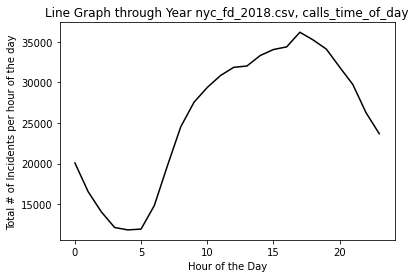

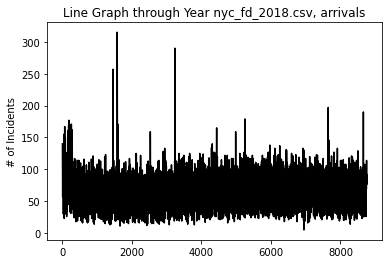

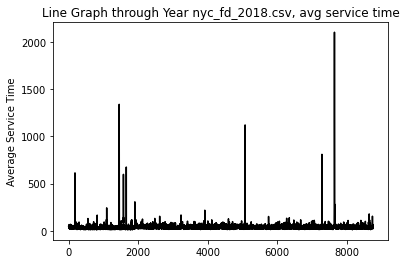

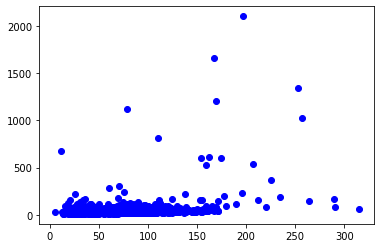

In [77]:
for name, obj in stationarity_map.items():
    plot_line_graph(name, obj)
